In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
import datetime
import os
warnings.filterwarnings('ignore')

df = pd.read_csv('Titanic-Dataset.csv')

df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df['Fare'].fillna(df['Fare'].median(), inplace=True)
df['Cabin'] = df['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)

df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')

label_encoders = {}
categorical_cols = ['Sex', 'Embarked', 'Title']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin', 'FamilySize', 'IsAlone', 'Title']
X = df[features]
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler_minmax = MinMaxScaler()
X_train_minmax = scaler_minmax.fit_transform(X_train)
X_test_minmax = scaler_minmax.transform(X_test)

scaler_standard = StandardScaler()
X_train_standard = scaler_standard.fit_transform(X_train)
X_test_standard = scaler_standard.transform(X_test)

X_train_orig = X_train.values
X_test_orig = X_test.values

# Naive Bayes Classifier

## Определение
Вероятностный классификатор на основе теоремы Байеса с допущением о независимости признаков.

## Основные типы
1. **GaussianNB** - непрерывные признаки, нормальное распределение
2. **MultinomialNB** - дискретные счетчики (тексты)
3. **BernoulliNB** - бинарные признаки
4. **ComplementNB** - улучшенная версия MultinomialNB для несбалансированных данных

## Плюсы
- Быстрый обучение и предсказание
- Работает с малыми данными
- Простая реализация
- Устойчив к шуму

## Минусы
- Наивное допущение часто неверно
- Проблема нулевой вероятности
- Чувствительность к выбросам

## Области применения
- Классификация текстов (спам/тональность)
- Медицинская диагностика
- Рекомендательные системы

In [90]:
print("НАИВНЫЙ БАЙЕСОВСКИЙ КЛАССИФИКАТОР")

nb_models = {
    'GaussianNB': (GaussianNB(), 'standard'),
    'MultinomialNB': (MultinomialNB(), 'minmax'),
    'ComplementNB': (ComplementNB(), 'minmax'),
    'BernoulliNB': (BernoulliNB(), 'standard')
}

nb_results = {}
for name, (model, scaling_type) in nb_models.items():
    if scaling_type == 'standard':
        X_tr, X_te = X_train_standard, X_test_standard
    elif scaling_type == 'minmax':
        X_tr, X_te = X_train_minmax, X_test_minmax
    else:
        X_tr, X_te = X_train_orig, X_test_orig
    
    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)
    y_pred_proba = model.predict_proba(X_te)[:, 1] if hasattr(model, 'predict_proba') else None
    
    nb_results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 0.5
    }
    
    print(f"\n{name}:")
    print(f"  Accuracy:  {nb_results[name]['accuracy']:.4f}")
    print(f"  Precision: {nb_results[name]['precision']:.4f}")
    print(f"  Recall:    {nb_results[name]['recall']:.4f}")
    print(f"  F1-Score:  {nb_results[name]['f1']:.4f}")
    print(f"  AUC-ROC:   {nb_results[name]['roc_auc']:.4f}")

best_nb_model = max(nb_results.items(), key=lambda x: x[1]['accuracy'])
print(f"\nЛучшая модель Naive Bayes: {best_nb_model[0]} (Accuracy: {best_nb_model[1]['accuracy']:.4f})")

НАИВНЫЙ БАЙЕСОВСКИЙ КЛАССИФИКАТОР

GaussianNB:
  Accuracy:  0.7877
  Precision: 0.6914
  Recall:    0.8116
  F1-Score:  0.7467
  AUC-ROC:   0.8111

MultinomialNB:
  Accuracy:  0.6313
  Precision: 0.5333
  Recall:    0.3478
  F1-Score:  0.4211
  AUC-ROC:   0.7382

ComplementNB:
  Accuracy:  0.6704
  Precision: 0.5758
  Recall:    0.5507
  F1-Score:  0.5630
  AUC-ROC:   0.7382

BernoulliNB:
  Accuracy:  0.7486
  Precision: 0.6463
  Recall:    0.7681
  F1-Score:  0.7020
  AUC-ROC:   0.7748

Лучшая модель Naive Bayes: GaussianNB (Accuracy: 0.7877)


Из полученных результатов мы видим что в данном случае лучшей моделью оказалась GaussianNB.
Метрика по которой выбирали лучшую модель: Accuracy(Точность)

# Деревья решений (Decision Tree)

## Определение
Алгоритм, который строит древовидную структуру для принятия решений через последовательные вопросы о признаках.

## Основная идея
Рекурсивное разбиение данных на подгруппы по условиям "если-то".

### Для регрессии:
- **MSE** (среднеквадратичная ошибка)
- **MAE** (средняя абсолютная ошибка)

### Преимущества
- Простота интерпретации
- Не требует нормализации данных
- Автоматический отбор признаков
- Работает с категориальными и числовыми данными

### Недостатки
- Склонность к переобучению
- Нестабильность (малые изменения → другое дерево)
- Неэффективность для линейных зависимостей

In [91]:
print("ДЕРЕВО РЕШЕНИЙ")

dt_params = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}
dt = DecisionTreeClassifier(random_state=42)
dt_grid = GridSearchCV(dt, dt_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=0)
dt_grid.fit(X_train_orig, y_train)
dt_best = dt_grid.best_estimator_

print(f"Лучшие параметры: {dt_grid.best_params_}")
print(f"Лучшая точность на CV: {dt_grid.best_score_:.4f}")

y_pred_dt = dt_best.predict(X_test_orig)
y_pred_proba_dt = dt_best.predict_proba(X_test_orig)[:, 1]

dt_results = {
    'accuracy': accuracy_score(y_test, y_pred_dt),
    'precision': precision_score(y_test, y_pred_dt),
    'recall': recall_score(y_test, y_pred_dt),
    'f1': f1_score(y_test, y_pred_dt),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_dt)
}

print(f"Test Accuracy:  {dt_results['accuracy']:.4f}")
print(f"Test Precision: {dt_results['precision']:.4f}")
print(f"Test Recall:    {dt_results['recall']:.4f}")
print(f"Test F1-Score:  {dt_results['f1']:.4f}")
print(f"Test AUC-ROC:   {dt_results['roc_auc']:.4f}")


ДЕРЕВО РЕШЕНИЙ


Лучшие параметры: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}
Лучшая точность на CV: 0.8119
Test Accuracy:  0.7933
Test Precision: 0.7667
Test Recall:    0.6667
Test F1-Score:  0.7132
Test AUC-ROC:   0.8074


# Линейный дискриминантный анализ (LDA)

## Определение
Алгоритм снижения размерности и классификации, который ищет линейные комбинации признаков, наилучшим образом разделяющие классы.

## Основная идея
Максимизировать расстояние между средними классами, минимизируя разброс внутри классов.

## Ключевые предположения
1. **Нормальность** - признаки распределены нормально
2. **Гомоскедастичность** - одинаковая ковариация для всех классов
3. **Независимость** наблюдений

## Преимущества
- Учитывает информацию о классах
- Устойчив к выбросам
- Эффективен для многоклассовых задач
- Меньше склонен к переобучению

## Недостатки
- Чувствителен к нарушению предположений
- Предполагает линейную разделимость
- Неэффективен при нелинейных границах

In [92]:
print("ЛИНЕЙНЫЙ ДИСКРИМИНАНТНЫЙ АНАЛИЗ")

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_standard, y_train)

y_pred_lda = lda.predict(X_test_standard)
y_pred_proba_lda = lda.predict_proba(X_test_standard)[:, 1]

lda_results = {
    'accuracy': accuracy_score(y_test, y_pred_lda),
    'precision': precision_score(y_test, y_pred_lda),
    'recall': recall_score(y_test, y_pred_lda),
    'f1': f1_score(y_test, y_pred_lda),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_lda)
}

print(f"Accuracy:  {lda_results['accuracy']:.4f}")
print(f"Precision: {lda_results['precision']:.4f}")
print(f"Recall:    {lda_results['recall']:.4f}")
print(f"F1-Score:  {lda_results['f1']:.4f}")
print(f"AUC-ROC:   {lda_results['roc_auc']:.4f}")

ЛИНЕЙНЫЙ ДИСКРИМИНАНТНЫЙ АНАЛИЗ
Accuracy:  0.7989
Precision: 0.7538
Recall:    0.7101
F1-Score:  0.7313
AUC-ROC:   0.8511


# Метод опорных векторов (SVM)

## Определение
Алгоритм для классификации и регрессии, ищущий оптимальную гиперплоскость для разделения классов.

## Основная идея
Найти гиперплоскость с максимальным зазором (margin) между классами.

## Ключевые концепции

### Опорные векторы
- Ближайшие к гиперплоскости точки
- Определяют положение разделяющей границы

## Преимущества
- Эффективен в высокоразмерных пространствах
- Устойчив к переобучению (при правильном C)
- Работает с нелинейными границами (через ядра)
- Хорошая обобщающая способность

## Недостатки
- Вычислительно дорогой для больших данных
- Чувствителен к выбросам
- Требует тюнинга гиперпараметров
- Плохая интерпретируемость (с ядрами)

In [93]:
print("МЕТОД ОПОРНЫХ ВЕКТОРОВ\n")

svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
svm = SVC(probability=True, random_state=42)
svm_grid = GridSearchCV(svm, svm_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=0)
svm_grid.fit(X_train_standard, y_train)
svm_best = svm_grid.best_estimator_

print(f"Лучшие параметры: {svm_grid.best_params_}")
print(f"Лучшая точность на CV: {svm_grid.best_score_:.4f}")

y_pred_svm = svm_best.predict(X_test_standard)
y_pred_proba_svm = svm_best.predict_proba(X_test_standard)[:, 1]

svm_results = {
    'accuracy': accuracy_score(y_test, y_pred_svm),
    'precision': precision_score(y_test, y_pred_svm),
    'recall': recall_score(y_test, y_pred_svm),
    'f1': f1_score(y_test, y_pred_svm),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_svm)
}

print(f"Test Accuracy:  {svm_results['accuracy']:.4f}")
print(f"Test Precision: {svm_results['precision']:.4f}")
print(f"Test Recall:    {svm_results['recall']:.4f}")
print(f"Test F1-Score:  {svm_results['f1']:.4f}")
print(f"Test AUC-ROC:   {svm_results['roc_auc']:.4f}")

МЕТОД ОПОРНЫХ ВЕКТОРОВ

Лучшие параметры: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Лучшая точность на CV: 0.8245
Test Accuracy:  0.8324
Test Precision: 0.7910
Test Recall:    0.7681
Test F1-Score:  0.7794
Test AUC-ROC:   0.8580


# Метод k-ближайших соседей (k-NN)

## Определение
Неконтролируемый алгоритм классификации/регрессии, основанный на близости объектов в пространстве признаков.

## Основная идея
"Скажи мне, кто твои соседи, и я скажу, кто ты"

## Алгоритм работы
1. Вычислить расстояния до всех точек
2. Найти k ближайших соседей
3. Для классификации: голосование большинства
4. Для регрессии: 

## Преимущества
- Простота реализации
- Нет этапа обучения
- Адаптируется к новым данным
- Работает с нелинейными границами

## Недостатки
- Медленный на предсказании
- Чувствителен к выбросам
- Требует нормализации признаков
- Плохо с большими размерностями

In [94]:
print("МЕТОД K-БЛИЖАЙШИХ СОСЕДЕЙ\n")

knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, knn_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=0)
knn_grid.fit(X_train_standard, y_train)
knn_best = knn_grid.best_estimator_

print(f"Лучшие параметры: {knn_grid.best_params_}")
print(f"Лучшая точность на CV: {knn_grid.best_score_:.4f}")

y_pred_knn = knn_best.predict(X_test_standard)
y_pred_proba_knn = knn_best.predict_proba(X_test_standard)[:, 1]

knn_results = {
    'accuracy': accuracy_score(y_test, y_pred_knn),
    'precision': precision_score(y_test, y_pred_knn),
    'recall': recall_score(y_test, y_pred_knn),
    'f1': f1_score(y_test, y_pred_knn),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_knn)
}

print(f"Test Accuracy:  {knn_results['accuracy']:.4f}")
print(f"Test Precision: {knn_results['precision']:.4f}")
print(f"Test Recall:    {knn_results['recall']:.4f}")
print(f"Test F1-Score:  {knn_results['f1']:.4f}")
print(f"Test AUC-ROC:   {knn_results['roc_auc']:.4f}")

МЕТОД K-БЛИЖАЙШИХ СОСЕДЕЙ

Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}
Лучшая точность на CV: 0.8273
Test Accuracy:  0.7989
Test Precision: 0.7260
Test Recall:    0.7681
Test F1-Score:  0.7465
Test AUC-ROC:   0.8406


In [95]:
print("СВОДНОЕ СРАВНЕНИЕ ВСЕХ КЛАССИФИКАТОРОВ\n")

all_results = []

all_results.append({
    'Model': best_nb_model[0] + ' (best NB)',
    **best_nb_model[1]
})

for model_name, results_dict, model_type in [
    ('Decision Tree', dt_results, 'Tree'),
    ('LDA', lda_results, 'LDA'),
    ('SVM', svm_results, 'SVM'),
    ('KNN', knn_results, 'KNN')
]:
    all_results.append({
        'Model': model_name,
        **results_dict
    })

comparison_df = pd.DataFrame(all_results)
comparison_df = comparison_df.sort_values('accuracy', ascending=False)

print("\nРейтинг моделей по точности (Accuracy):")
print(comparison_df.to_string(index=False))


СВОДНОЕ СРАВНЕНИЕ ВСЕХ КЛАССИФИКАТОРОВ


Рейтинг моделей по точности (Accuracy):
               Model  accuracy  precision   recall       f1  roc_auc
                 SVM  0.832402   0.791045 0.768116 0.779412 0.857971
                 KNN  0.798883   0.726027 0.768116 0.746479 0.840646
                 LDA  0.798883   0.753846 0.710145 0.731343 0.851120
       Decision Tree  0.793296   0.766667 0.666667 0.713178 0.807444
GaussianNB (best NB)  0.787709   0.691358 0.811594 0.746667 0.811067


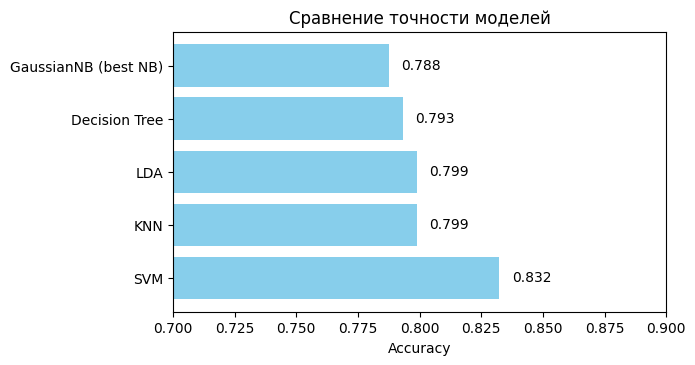

In [96]:
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
bars = plt.barh(comparison_df['Model'], comparison_df['accuracy'], color='skyblue')
plt.xlabel('Accuracy')
plt.title('Сравнение точности моделей')
plt.xlim([0.7, 0.9])
for bar, acc in zip(bars, comparison_df['accuracy']):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
             f'{acc:.3f}', va='center')

### Сравнение по Accuracy
#### Лучшая модель: SVM(0.832)
#### Худшая модель: GaussianNB(0.788)

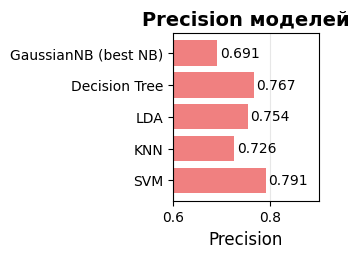

In [97]:
plt.subplot(2, 3, 2)
bars_precision = plt.barh(comparison_df['Model'], comparison_df['precision'], 
                          color='lightcoral')
plt.xlabel('Precision', fontsize=12)
plt.title('Precision моделей', fontsize=14, fontweight='bold')
plt.xlim([0.6, 0.9])
plt.grid(True, alpha=0.3, axis='x')
for bar, prec in zip(bars_precision, comparison_df['precision']):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
             f'{prec:.3f}', va='center', fontsize=10)

### Сравнение по Precision
#### Лучшая модель: SVM(0.791)
#### Худшая модель: GaussianNB(0.691)

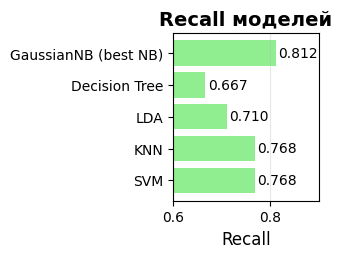

In [98]:
plt.subplot(2, 3, 3)
bars_recall = plt.barh(comparison_df['Model'], comparison_df['recall'], 
                       color='lightgreen')
plt.xlabel('Recall', fontsize=12)
plt.title('Recall моделей', fontsize=14, fontweight='bold')
plt.xlim([0.6, 0.9])
plt.grid(True, alpha=0.3, axis='x')
for bar, rec in zip(bars_recall, comparison_df['recall']):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
             f'{rec:.3f}', va='center', fontsize=10)

### Сравнение по Recall
#### Лучшая модель: GaussianNB(0.812)
#### Худшая модель: Decision Tree(0.667)

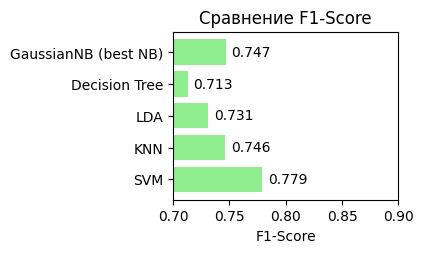

In [99]:
plt.subplot(2, 2, 3)
bars = plt.barh(comparison_df['Model'], comparison_df['f1'], color='lightgreen')
plt.xlabel('F1-Score')
plt.title('Сравнение F1-Score')
plt.xlim([0.7, 0.9])
for bar, f1 in zip(bars, comparison_df['f1']):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
             f'{f1:.3f}', va='center')

### Сравнение по F1-Score
#### Лучшая модель: SVM(0.812)
#### Худшая модель: Decision Tree(0.667)

ROC-КРИВЫЕ ДЛЯ КЛАССИЧЕСКИХ МОДЕЛЕЙ


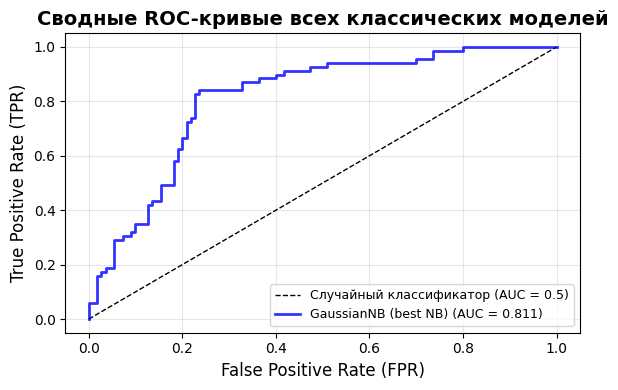

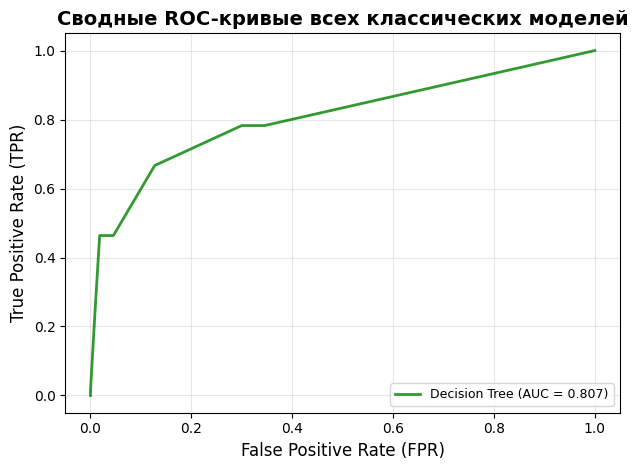

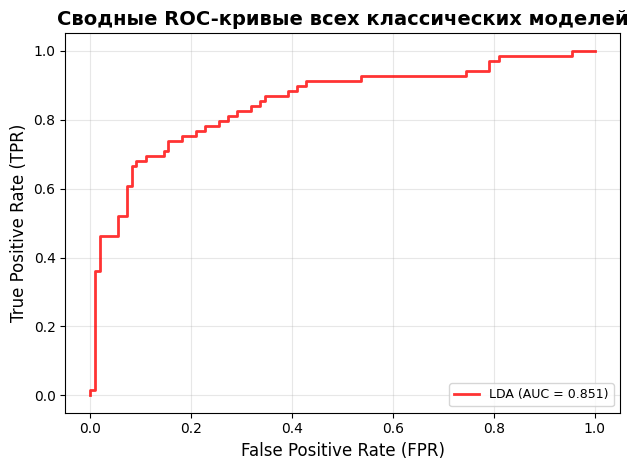

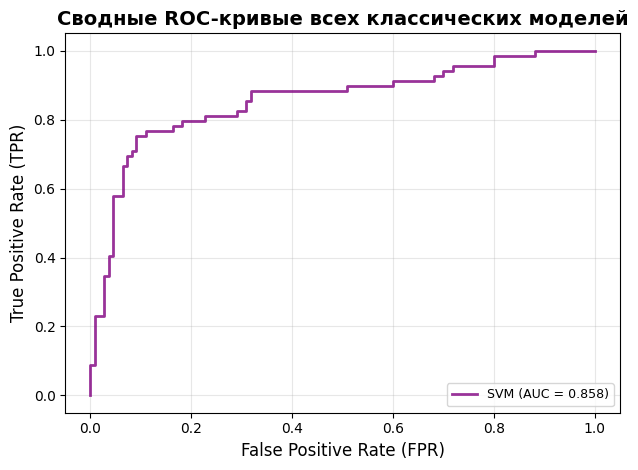

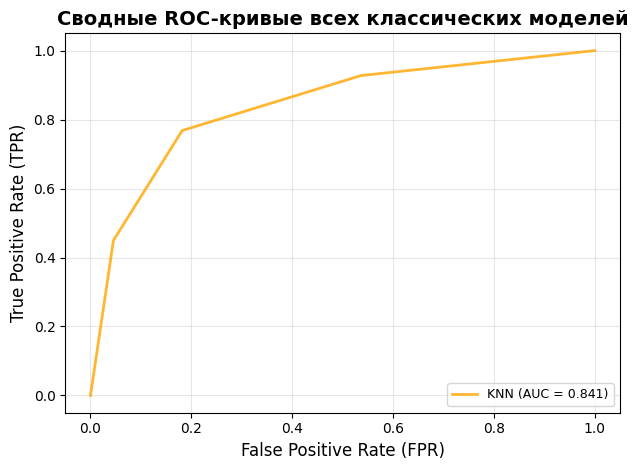

In [100]:
print("ROC-КРИВЫЕ ДЛЯ КЛАССИЧЕСКИХ МОДЕЛЕЙ")

models_predictions = {}

best_nb_name = best_nb_model[0]
best_nb_tuple = nb_models[best_nb_name]
models_predictions[f'{best_nb_name} (best NB)'] = {
    'model': best_nb_tuple[0],
    'scaling': best_nb_tuple[1],
    'y_pred_proba': None
}

models_predictions['Decision Tree'] = {
    'model': dt_best,
    'scaling': 'original',
    'y_pred_proba': y_pred_proba_dt
}

models_predictions['LDA'] = {
    'model': lda,
    'scaling': 'standard',
    'y_pred_proba': y_pred_proba_lda
}

models_predictions['SVM'] = {
    'model': svm_best,
    'scaling': 'standard',
    'y_pred_proba': y_pred_proba_svm
}

models_predictions['KNN'] = {
    'model': knn_best,
    'scaling': 'standard',
    'y_pred_proba': y_pred_proba_knn
}

plt.figure(figsize=(6, 4))
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

plt.plot([0, 1], [0, 1], 'k--', label='Случайный классификатор (AUC = 0.5)', linewidth=1)

for i, (model_name, model_info) in enumerate(models_predictions.items()):
    if model_info['scaling'] == 'standard':
        X_te = X_test_standard
    elif model_info['scaling'] == 'minmax':
        X_te = X_test_minmax
    else:
        X_te = X_test_orig
    
    if model_info['y_pred_proba'] is not None:
        y_pred_proba = model_info['y_pred_proba']
    else:
        y_pred_proba = model_info['model'].predict_proba(X_te)[:, 1]
    
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=colors[i % len(colors)], 
             label=f'{model_name} (AUC = {roc_auc:.3f})', 
             linewidth=2, alpha=0.8)
    plt.xlabel('False Positive Rate (FPR)', fontsize=12)
    plt.ylabel('True Positive Rate (TPR)', fontsize=12)
    plt.title('Сводные ROC-кривые всех классических моделей', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.tight_layout()
    plt.show()


## Лидеры: SVM и LDA
- SVM (AUC = 0.858) — наилучшая разделительная способность
- LDA (AUC = 0.851) — почти не уступает SVM, отличный результат
- Оба классификатора значительно превосходят случайный классификатор (AUC=0.5)

## Хорошие результаты: KNN
- AUC = 0.841 — солидный показатель
- Заметно лучше базовых моделей (Naive Bayes и Decision Tree)

## Требуют улучшения:
#### Decision Tree (AUC = 0.807)
- Самый низкий AUC среди "умных" моделей
- Вероятно переобучение или неоптимальные гиперпараметры

#### GaussianNB (AUC = 0.811)
- Низкий AUC объясняется нарушением предположения о независимости признаков
- Тем не менее, лучше Decision Tree

АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ (Decision Tree)
   Признак  Важность
       Sex  0.558360
    Pclass  0.183523
       Age  0.102304
     Cabin  0.098694
FamilySize  0.039910
      Fare  0.017208
     SibSp  0.000000
  Embarked  0.000000
     Parch  0.000000
   IsAlone  0.000000
     Title  0.000000


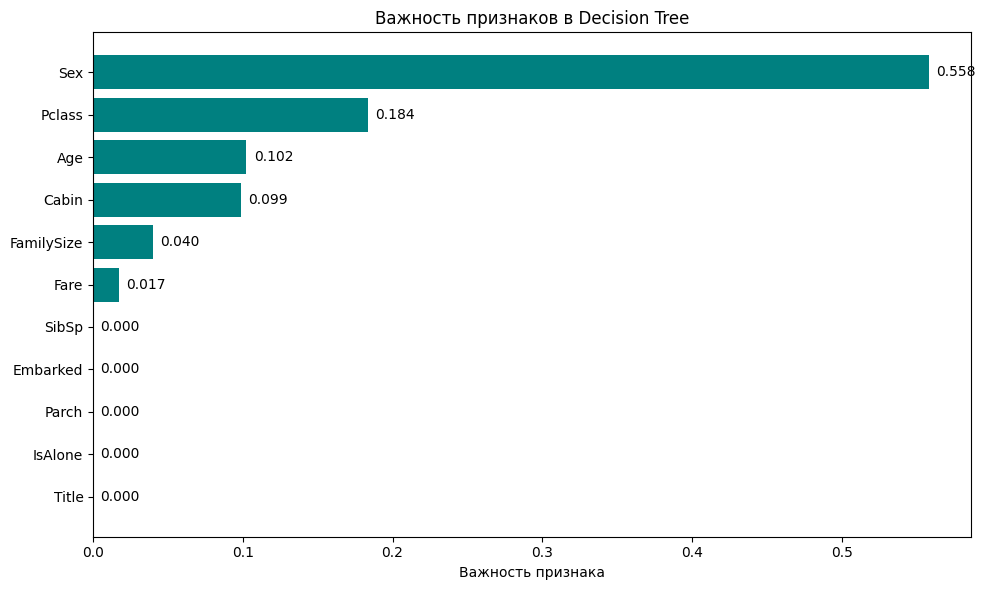

In [101]:
print("АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ (Decision Tree)")

if hasattr(dt_best, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Признак': features,
        'Важность': dt_best.feature_importances_
    }).sort_values('Важность', ascending=False)
    
    print(feature_importance.to_string(index=False))
    
    plt.figure(figsize=(10, 6))
    bars = plt.barh(feature_importance['Признак'], feature_importance['Важность'], color='teal')
    plt.xlabel('Важность признака')
    plt.title('Важность признаков в Decision Tree')
    plt.gca().invert_yaxis()
    
    for bar, imp in zip(bars, feature_importance['Важность']):
        plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
                 f'{imp:.3f}', va='center')
    
    plt.tight_layout()
    plt.show()

In [102]:
print("НЕЙРОННАЯ СЕТЬ НА TENSORFLOW\n")

X_nn = X_train_standard
y_nn = y_train.values

def create_baseline_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_nn.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    return model

learning_rates = [0.0001, 0.001, 0.01]
architectures = [
    [32, 16],      
    [64, 32, 16],  
    [128, 64, 32]  
]

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
best_score = 0
best_params = {}
cv_results = []

print("\nЗапуск 5-кратной кросс-валидации с Grid Search...")

for lr_idx, lr in enumerate(learning_rates):
    for arch_idx, arch in enumerate(architectures):
        fold_scores = []
        fold_histories = []
        
        print(f"\nLR: {lr}, Архитектура: {arch}")
        print("-" * 40)
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(X_nn)):
            fold_log_dir = os.path.join(log_dir, f"lr_{lr}_arch_{'_'.join(map(str, arch))}_fold_{fold+1}")
            
            X_train_fold, X_val_fold = X_nn[train_idx], X_nn[val_idx]
            y_train_fold, y_val_fold = y_nn[train_idx], y_nn[val_idx]
            
            model = Sequential()
            model.add(Dense(arch[0], activation='relu', input_shape=(X_nn.shape[1],)))
            model.add(BatchNormalization())
            model.add(Dropout(0.3))
            
            for units in arch[1:]:
                model.add(Dense(units, activation='relu'))
                model.add(BatchNormalization())
                model.add(Dropout(0.3))
            
            model.add(Dense(1, activation='sigmoid'))
            
            optimizer = Adam(learning_rate=lr)
            model.compile(
                optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy']
            )
            
            callbacks = [
                EarlyStopping(patience=10, restore_best_weights=True, verbose=0),
                TensorBoard(log_dir=fold_log_dir, histogram_freq=1)
            ]
            
            history = model.fit(
                X_train_fold, y_train_fold,
                validation_data=(X_val_fold, y_val_fold),
                epochs=100,
                batch_size=32,
                callbacks=callbacks,
                verbose=0
            )
            
            val_loss, val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)
            fold_scores.append(val_acc)
            fold_histories.append(history)
            
            print(f"  Fold {fold+1}: Accuracy = {val_acc:.4f}")
        
        avg_score = np.mean(fold_scores)
        std_score = np.std(fold_scores)
        
        cv_results.append({
            'learning_rate': lr,
            'architecture': arch,
            'avg_accuracy': avg_score,
            'std_accuracy': std_score,
            'fold_scores': fold_scores
        })
        
        print(f"  Средняя точность: {avg_score:.4f} (±{std_score:.4f})")
        
        if avg_score > best_score:
            best_score = avg_score
            best_params = {
                'learning_rate': lr,
                'architecture': arch,
                'avg_accuracy': avg_score
            }


НЕЙРОННАЯ СЕТЬ НА TENSORFLOW


Запуск 5-кратной кросс-валидации с Grid Search...

LR: 0.0001, Архитектура: [32, 16]
----------------------------------------
  Fold 1: Accuracy = 0.7692
  Fold 2: Accuracy = 0.7972
  Fold 3: Accuracy = 0.7606
  Fold 4: Accuracy = 0.8028
  Fold 5: Accuracy = 0.8451
  Средняя точность: 0.7950 (±0.0297)

LR: 0.0001, Архитектура: [64, 32, 16]
----------------------------------------
  Fold 1: Accuracy = 0.7762
  Fold 2: Accuracy = 0.7832
  Fold 3: Accuracy = 0.7958
  Fold 4: Accuracy = 0.8028
  Fold 5: Accuracy = 0.8662
  Средняя точность: 0.8048 (±0.0321)

LR: 0.0001, Архитектура: [128, 64, 32]
----------------------------------------
  Fold 1: Accuracy = 0.7902
  Fold 2: Accuracy = 0.3566
  Fold 3: Accuracy = 0.8169
  Fold 4: Accuracy = 0.8239
  Fold 5: Accuracy = 0.8803
  Средняя точность: 0.7336 (±0.1907)

LR: 0.001, Архитектура: [32, 16]
----------------------------------------
  Fold 1: Accuracy = 0.7972
  Fold 2: Accuracy = 0.7832
  Fold 3: Accuracy =

### Влияние Learning Rate:
- LR=0.001 → лучшие и самые стабильные результаты
- LR=0.0001 → слишком медленное обучение (низкая точность)
- LR=0.01 → хорошие результаты, но чуть хуже оптимального

### Влияние архитектуры сети:
- Средние сети [64, 32, 16] → оптимальный баланс
- Мелкие сети [32, 16] → немного недосчитывают
- Глубокие сети [128, 64, 32] → проблемы с обучением при малом LR

### Проблемы обучения:
- Высокая дисперсия в некоторых фолдах (особенно при LR=0.0001)
- Fold 2 в [128, 64, 32], LR=0.0001: точность 35.66% → сеть не сходится

### Стабильность моделей:
- Наименьший разброс: [128, 64, 32], LR=0.001 (std=0.0295)
- Наибольший разброс: [128, 64, 32], LR=0.0001 (std=0.1907)

### Оптимальная конфигурация:
- Learning Rate: 0.001
- Архитектура: [64, 32, 16]
- Точность: 82.73% (лучший результат)

In [ ]:
print("РЕЗУЛЬТАТЫ КРОСС-ВАЛИДАЦИИ\n")

for i, result in enumerate(cv_results, 1):
    print(f"\nКонфигурация {i}:")
    print(f"  Learning rate: {result['learning_rate']}")
    print(f"  Архитектура: {result['architecture']}")
    print(f"  Средняя точность: {result['avg_accuracy']:.4f} (±{result['std_accuracy']:.4f})")
    print(f"  Точность по фолдам: {[f'{s:.4f}' for s in result['fold_scores']]}")

print(f"\nЛучшая конфигурация:")
print(f"  Learning rate: {best_params['learning_rate']}")
print(f"  Архитектура: {best_params['architecture']}")
print(f"  Средняя точность: {best_params['avg_accuracy']:.4f}")

print("ОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ")

final_model = Sequential()
final_model.add(Dense(best_params['architecture'][0], activation='relu', 
                     input_shape=(X_nn.shape[1],)))
final_model.add(BatchNormalization())
final_model.add(Dropout(0.3))

for units in best_params['architecture'][1:]:
    final_model.add(Dense(units, activation='relu'))
    final_model.add(BatchNormalization())
    final_model.add(Dropout(0.3))

final_model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=best_params['learning_rate'])
final_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 
             tf.keras.metrics.AUC(name='auc')]
)

final_log_dir = os.path.join(log_dir, "final_model")
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True, verbose=1),
    TensorBoard(log_dir=final_log_dir, histogram_freq=1),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy')
]

history = final_model.fit(
    X_train_standard, y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


РЕЗУЛЬТАТЫ КРОСС-ВАЛИДАЦИИ


Конфигурация 1:
  Learning rate: 0.0001
  Архитектура: [32, 16]
  Средняя точность: 0.7950 (±0.0297)
  Точность по фолдам: ['0.7692', '0.7972', '0.7606', '0.8028', '0.8451']

Конфигурация 2:
  Learning rate: 0.0001
  Архитектура: [64, 32, 16]
  Средняя точность: 0.8048 (±0.0321)
  Точность по фолдам: ['0.7762', '0.7832', '0.7958', '0.8028', '0.8662']

Конфигурация 3:
  Learning rate: 0.0001
  Архитектура: [128, 64, 32]
  Средняя точность: 0.7336 (±0.1907)
  Точность по фолдам: ['0.7902', '0.3566', '0.8169', '0.8239', '0.8803']

Конфигурация 4:
  Learning rate: 0.001
  Архитектура: [32, 16]
  Средняя точность: 0.8189 (±0.0377)
  Точность по фолдам: ['0.7972', '0.7832', '0.7958', '0.8310', '0.8873']

Конфигурация 5:
  Learning rate: 0.001
  Архитектура: [64, 32, 16]
  Средняя точность: 0.8273 (±0.0390)
  Точность по фолдам: ['0.7762', '0.8182', '0.8099', '0.8380', '0.8944']

Конфигурация 6:
  Learning rate: 0.001
  Архитектура: [128, 64, 32]
  Средняя точност

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5958 - auc: 0.6143 - loss: 0.8159 - precision_4: 0.4740 - recall_4: 0.6372 - val_accuracy: 0.7972 - val_auc: 0.8317 - val_loss: 0.6403 - val_precision_4: 0.7636 - val_recall_4: 0.7241
Epoch 2/150
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5312 - auc: 0.6215 - loss: 0.7048 - precision_4: 0.4375 - recall_4: 0.5385

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6257 - auc: 0.6687 - loss: 0.7468 - precision_4: 0.5039 - recall_4: 0.6047 - val_accuracy: 0.8392 - val_auc: 0.8571 - val_loss: 0.5959 - val_precision_4: 0.7966 - val_recall_4: 0.8103
Epoch 3/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6643 - auc: 0.7134 - loss: 0.6755 - precision_4: 0.5496 - recall_4: 0.6186 - val_accuracy: 0.8252 - val_auc: 0.8509 - val_loss: 0.5624 - val_precision_4: 0.7895 - val_recall_4: 0.7759
Epoch 4/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7311 - auc: 0.7846 - loss: 0.5779 - precision_4: 0.6230 - recall_4: 0.7302 - val_accuracy: 0.8042 - val_auc: 0.8450 - val_loss: 0.5370 - val_precision_4: 0.7679 - val_recall_4: 0.7414
Epoch 5/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7118 - auc: 0.7705 - loss: 0.6125 - precision_4: 0.6024 - recall_4: 0.6977 - val_accuracy: 0.7972 - val_auc: 0.8459 - val_loss: 0.5201 - val_precision_4: 0.7843 - val_recall_4: 0.6897
Epoch 6/150


In [104]:
print("ОЦЕНКА НА ТЕСТОВЫХ ДАННЫХ")

test_results = final_model.evaluate(X_test_standard, y_test, verbose=0)
test_loss, test_acc, test_precision, test_recall, test_auc = test_results

y_pred_nn = (final_model.predict(X_test_standard, verbose=0) > 0.5).astype(int).flatten()
y_pred_proba_nn = final_model.predict(X_test_standard, verbose=0).flatten()

test_f1 = f1_score(y_test, y_pred_nn)
test_roc_auc = roc_auc_score(y_test, y_pred_proba_nn)

print(f"Test Loss:          {test_loss:.4f}")
print(f"Test Accuracy:      {test_acc:.4f}")
print(f"Test Precision:     {test_precision:.4f}")
print(f"Test Recall:        {test_recall:.4f}")
print(f"Test F1-Score:      {test_f1:.4f}")
print(f"Test AUC (Keras):   {test_auc:.4f}")
print(f"Test ROC-AUC:       {test_roc_auc:.4f}")

print("СРАВНЕНИЕ С BASELINE МОДЕЛЬЮ")

baseline_model = create_baseline_model()
baseline_model.fit(
    X_train_standard, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=0
)

baseline_acc = baseline_model.evaluate(X_test_standard, y_test, verbose=0)[1]
print(f"Baseline Accuracy:    {baseline_acc:.4f}")
print(f"Final Model Accuracy: {test_acc:.4f}")
print(f"Улучшение:            {test_acc - baseline_acc:.4f}")

nn_results = {
    'accuracy': test_acc,
    'precision': test_precision,
    'recall': test_recall,
    'f1': test_f1,
    'roc_auc': test_roc_auc
}
all_results.append({
    'Model': 'Neural Network',
    **nn_results
})


ОЦЕНКА НА ТЕСТОВЫХ ДАННЫХ
Test Loss:          0.4682
Test Accuracy:      0.7933
Test Precision:     0.7581
Test Recall:        0.6812
Test F1-Score:      0.7176
Test AUC (Keras):   0.8346
Test ROC-AUC:       0.8329
СРАВНЕНИЕ С BASELINE МОДЕЛЬЮ
Baseline Accuracy:    0.7933
Final Model Accuracy: 0.7933
Улучшение:            0.0000


ФИНАЛЬНОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ


Рейтинг моделей:

               Model  accuracy  precision   recall       f1  roc_auc
                 SVM  0.832402   0.791045 0.768116 0.779412 0.857971
                 LDA  0.798883   0.753846 0.710145 0.731343 0.851120
                 KNN  0.798883   0.726027 0.768116 0.746479 0.840646
      Neural Network  0.793296   0.758065 0.681159 0.717557 0.832938
       Decision Tree  0.793296   0.766667 0.666667 0.713178 0.807444
GaussianNB (best NB)  0.787709   0.691358 0.811594 0.746667 0.811067


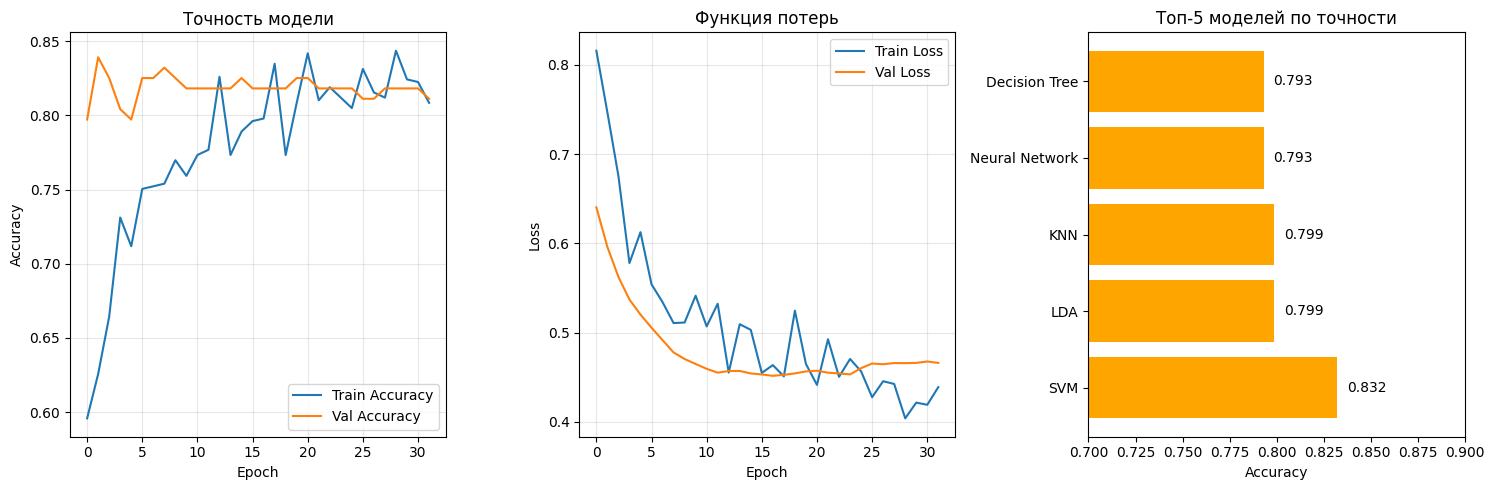

In [105]:
print("ФИНАЛЬНОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ\n")

final_comparison = pd.DataFrame(all_results)
final_comparison = final_comparison.sort_values('accuracy', ascending=False)

print("\nРейтинг моделей:\n")
print(final_comparison.to_string(index=False))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Точность модели')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Функция потерь')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
top_models = final_comparison.head(5)
plt.barh(top_models['Model'], top_models['accuracy'], color='orange')
plt.xlabel('Accuracy')
plt.title('Топ-5 моделей по точности')
plt.xlim([0.7, 0.9])
for i, (model, acc) in enumerate(zip(top_models['Model'], top_models['accuracy'])):
    plt.text(acc + 0.005, i, f'{acc:.3f}', va='center')

plt.tight_layout()
plt.show()
